# Inverting gradient attack

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam, AdamW
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.functional.image import total_variation
import torchinfo
from image_classification.utils import trange

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## ResNet-18

For quick prototyping, also consider using `ConvNet16`, a 1.6M-parameter model that is much smaller than `ResNet18`. Experiments can be made on both models or on only one of them.

In [3]:
from image_classification.models import ResNet18, ConvNet16
from image_classification.datasets import cifar10_train_test, cifar100_train_test
from image_classification.nn import train_loop, train_val_loop, test_epoch

Using cuda device


In [4]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by theses datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N_aux = N_val
N = len(training_data) - N_val - N_aux
# This works since training data is already shuffled
training_data, val_data, aux_data = training_data.split([N, N_val, N_aux])

batch_size = 100
N, N_val, N_aux, N_test

Loading CIFAR-10


(40000, 5000, 5000, 10000)

In [5]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)
aux_loader = DataLoader(aux_data, batch_size, drop_last=True)

### Hyperparameters

In [6]:
lr = 1e-3
weight_decay = 5e-4
# For learning rate scheduling
max_lr = 0.1

epochs = 6
steps_per_epoch = N // batch_size

lr_sched_params = dict(max_lr=max_lr, epochs=epochs, steps_per_epoch=steps_per_epoch)

criterion = CrossEntropyLoss()

top_k = {10: 1, 100: 5}[num_classes]

metric = MulticlassAccuracy(num_classes=num_classes, top_k=top_k)

### Optimizer (TODO: compare SGD & Adam)

In [7]:
def make_optimizer(model: nn.Module, opt_name='adamw', lr=lr, weight_decay=weight_decay, **kwargs) -> Optimizer:
    cls = {'sgd': SGD, 'adam': Adam, 'adamw': AdamW}[opt_name]
    return cls(model.parameters(), lr=lr, weight_decay=weight_decay, **kwargs)

## Inverting gradient attack

In [8]:
# TODO: gradients per parameter instead?
def model_gradients(model: nn.Module) -> Tensor:
    """
    Returns the model gradients without detaching them.
    """
    grads = [
        param.grad.flatten()
        for param in model.parameters()
    ]
    return torch.cat(grads)

def average_model_gradient(model: nn.Module, batch_size: int) -> Tensor:
    """
    Returns the model gradient averaged over the batch size.

    Assumes the gradients have already been computed with loss backpropagation.
    """
    return model_gradients(model).detach().clone() / batch_size

In [9]:
max_data_variation = training_data.max_data_variation()

In [10]:
from enum import Enum

class GradientAttack(Enum):
    """
    A type of gradient attack.
    """
    # Inverting gradient reconstruction attack (Geiping et al., 2020)
    # https://arxiv.org/abs/2003.14053v2)
    RECONSTRUCTION = -1

    # Gradient Ascent (Blanchard et al., 2017)
    ASCENT = 0

    # Orthogonal Gradient
    ORTHOGONAL = 1

    # Little is Enough (Baruch et al., 2019; Shejwalkar & Houmansadr, 2021)
    # https://arxiv.org/abs/1902.06156
    LITTLE_IS_ENOUGH = 2

In [11]:
# https://github.com/pytorch/pytorch/issues/23900
def cycle(iterable: DataLoader):
    """
    Cycle through the elements of a dataloader infinitely.
    """
    iterator = iter(iterable)
    while True:
        try:
            yield next(iterator)
        except StopIteration:
            iterator = iter(iterable)

class GradientEstimator:
    """A class for estimating model gradient statistics (mean and standard deviation)."""
    def average_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        """
        Estimate the average gradient on a clean-distributed dataset.

        # Requirements
        This function must not modify the model gradients.
        """
        raise NotImplementedError
    
    def std_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        """
        Estimate the gradient per-coordinate standard deviation on a clean-distributed dataset.
        """
        raise NotImplementedError

class OmniscientGradientEstimator(GradientEstimator):
    """
    Estimates the average gradient assuming it has already been computed
    on a mini-batch with loss backpropagation.

    # Example
    ```python
    grad_estim = OmniscientGradientEstimator(batch_size)
    loss = criterion(model(X), y)
    loss.backward()
    avg_clean_gradient = grad_estim.average_clean_gradient(model, criterion)
    ```
    """
    def __init__(self, batch_size: int):
        super().__init__()
        self.batch_size = batch_size
    
    def average_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        return average_model_gradient(model, self.batch_size)

    def std_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        # FIXME: gradients have already been aggregated...
        raise NotImplementedError
    

class ShadowGradientEstimator(GradientEstimator):
    """
    Estimate the average clean gradient with an auxiliary dataset
    that is similarly distributed to the training dataset.
    """
    def __init__(self, aux_loader: DataLoader):
        self.aux_loader = cycle(aux_loader)
    
    def average_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        model = deepcopy(model)
        # TODO: estimate on next mini-batch of aux_loader
        # WARNING: do not modify the original model, but the copied model!
        #
        # minor suggestion (optimization): identify samples that are consistently
        # close to the average and boost them.
        # also cache near-constant gradients if model is converging
        raise NotImplementedError
    
    def std_clean_gradient(self, model: nn.Module, criterion: _Loss):
        model = deepcopy(model)
        # FIXME: gradients have already been aggregated...
        raise NotImplementedError

In [12]:
class SampleInit:
    """Sample initialization method for inverting gradient attacks."""
    def __init__(self, dataset: Dataset):
        self.dataset = dataset

    def __call__(self) -> tuple[Tensor, Tensor]:
        raise NotImplementedError

class SampleInitRandomNoise(SampleInit):
    """Generate an image with random noise and a random label."""
    def __call__(self) -> tuple[Tensor, Tensor]:
        return self.dataset.random_sample_noise()

# FIXME: this would leak training data to the attacker.
# TODO: sample from auxiliary dataset instead
class SampleInitFromDataset(SampleInit):
    """Choose a random image from the dataset."""
    def __call__(self) -> tuple[Tensor, Tensor]:
        return self.dataset[np.random.randint(len(self.dataset))]

class SampleInitConstant(SampleInit):
    """Return a fixed starting image."""
    def __init__(self, X: Tensor, y: Tensor):
        self.X = X
        self.y = y
    
    def __call__(self) -> tuple[Tensor, Tensor]:
        return self.X, self.y

In [31]:
class GradientInverter:
    """Inverting gradient attack."""
    def __init__(
            self,
            method: GradientAttack,
            estimator: GradientEstimator,
            steps: int,
            sample_init: SampleInit,
            tv_coef = 0.0, # TODO: more ergonomic interface
            lr = 0.2, # TODO: find appropriate lr scheduling step
        ):
        self.method = method
        self.estimator = estimator
        self.steps = steps
        self.tv_coef = tv_coef
        self.lr = lr
        self.sample_init = sample_init
    
    def attack(self, model: nn.Module, criterion: _Loss) -> tuple[Tensor, Tensor]:
        """
        Create a poisoned data point with an inverting gradient attack.
        
        This function assumes that mini-batch loss gradients have been computed
        via backpropagation. It does not alter the model.

        WARNING: do not deepcopy the model before calling this function
        as the gradients will not be copied along.
        """
        avg_clean_gradient = self.estimator.average_clean_gradient(model, criterion)
        avg_clean_gradient.requires_grad_(False)
        
        # This detaches the model and its gradients
        model = deepcopy(model)
        model.eval()
        model.requires_grad_()
        model.zero_grad()

        # TODO: implement random restarts if sampling is not constant
        x_base, y_base = self.sample_init()
        
        x_base = x_base.to(device)
        y_base = F.one_hot(y_base, num_classes).float().to(device)
        # We optimize on both the image and the label (as a logit vector)
        opt = Adam([x_base, y_base], lr=self.lr)

        for _step in range(self.steps):
            # FIXME: seems necessary but `criterion` gradients only need be computed for `model`
            x_base.requires_grad_(True)
            y_base.requires_grad_(True)

            loss = criterion(model(x_base.unsqueeze(0)).squeeze(), y_base)
            loss.backward(create_graph=True) # Allows 2nd-order differentiation

            # TODO: gradients per parameter instead & weighted cosine similarity?
            g_p = model_gradients(model)

            match self.method:
                case GradientAttack.RECONSTRUCTION:
                    #loss_adv = (g_p - avg_clean_gradient).norm() ** 2
                    #TODO: (signed gradient updates) & learning rate decay (Geiping et al.)
                    loss_adv = 1.0 - torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)

                case GradientAttack.ASCENT:
                    cos_sim = torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)
                    # dot product increases the gradient size but makes unalignment easier
                    #loss_adv = g_p.dot(avg_clean_gradient)
                    loss_adv = cos_sim
                
                case GradientAttack.ORTHOGONAL:
                    cos_sim = torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)
                    loss_adv = cos_sim ** 2

                case GradientAttack.LITTLE_IS_ENOUGH:
                    # See Algorithm 3 in https://arxiv.org/pdf/1902.06156
                    # Estimate per-coordinate gradient std dev. with GradientEstimator
                    raise NotImplementedError

            if self.tv_coef:
                tv = total_variation(x_base.unsqueeze(0))
                normalization = x_base.numel() * 4 * max_data_variation ** 2
                loss_adv += self.tv_coef * tv / normalization

            #print(f"Inverting gradient step {step}: loss = {loss.item()}, cos_sim = {cos_sim.item()}")
            # Clear `loss` gradients on `x_base` and `y_base`
            opt.zero_grad()

            # TODO: improve efficiency, e.g with torch.autograd
            # Optimize `x_base`, `y_base`
            loss_adv.backward()
            opt.step()
            opt.zero_grad()
            model.zero_grad()

            # Avoids autograd graph errors when modifying tensor in-place
            x_base.requires_grad_(False)
            y_base.requires_grad_(False)
            # Projected optimization algorithm
            training_data.clip_to_data_range(x_base, inplace=True)
        
        # Take the softmax output as the one-hot label (Zhu et al., Deep Leakage from Gradients)
        y_base = y_base.argmax()
        return x_base, y_base


### Visualizing reconstruction attacks

In [32]:
def display_input_image(input: Tensor, label: Tensor, title='', cmap=None, ax: plt.Axes = None):
    """
    Displays an an input image to a neural network.

    `input`: a 3D tensor
    `cmap`: grayscale by default.
    """
    decoders = {
        10: training_data.decode_cifar10_image,
        100: training_data.decode_cifar100_image,
    }
    image = decoders[len(training_data.classes)](input)
    class_ = training_data.decode_target(label)

    if ax is None:
        _fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap, interpolation='nearest')
    if title:
        title = f"{class_} - {title}"
    else:
        title = class_
    ax.set_title(title, fontsize=7)

In [ ]:
def test_attack(
        inverter: GradientInverter,
        model: nn.Module, criterion: _Loss,
        X: Tensor, y: Tensor,
        ax_clean: plt.Axes, ax_reconstructed: plt.Axes,
        title=False
    ):
    model.eval()
    model.zero_grad()

    X, y = X.to(device), y.to(device)
    logits = model(X)
    loss = criterion(logits, y)
    loss.backward()

    # According to Zhao et al. (iDLG), the label information can be recovered
    # analytically, so we assume the attacker has access to the label.
    inverter.sample_init.label_hint(y[0])
    X_p, y_p = inverter.attack(model, criterion)
    
    clean_title, reconstructed_title = "", ""
    if title:
        clean_title = "Clean sample"
        reconstructed_title = f"Reconstructed sample, {inverter.steps} steps"
    display_input_image(
        X[0], y[0],
        title=clean_title,
        ax=ax_clean,
    )
    display_input_image(
        X_p, y_p,
        title=reconstructed_title,
        ax=ax_reconstructed,
    )

    return X, y, X_p, y_p

In [ ]:
def test_reconstruction(net: nn.Module, training_data: Dataset, n=5, steps=1000, tv_coef=0.1, lr=0.2):

    class SampleInitLabelHint(SampleInit):
        def __init__(self, inner: SampleInit):
            self._inner = inner
            self.y = None
  
        def label_hint(self, label: Tensor):
            self.y = label
        
        def __call__(self):
            X, _ = self._inner.__call__()
            assert self.y is not None
            y = self.y
            self.y = None
            return X, y

    reconstruction_inverter = GradientInverter(
        GradientAttack.RECONSTRUCTION,
        OmniscientGradientEstimator(batch_size=1),
        steps=steps,
        sample_init=SampleInitLabelHint(SampleInitRandomNoise(aux_data)),
        tv_coef=tv_coef,
        lr=lr,
    )
    loader = DataLoader(training_data, batch_size=1)

    fig, axes = plt.subplots(nrows=2, ncols=n, squeeze=False)
    for i, (X, y) in zip(range(n), loader):
        # TODO: also test with shadow gradient estimation w/ aux. dataset
        test_attack(reconstruction_inverter, net, criterion, X, y, axes[0, i], axes[1, i]);
    fig.suptitle(f"Reconstruction attacks against ResNet-18 on CIFAR-10\n{steps} steps, {lr=}, {tv_coef=}")
    fig.tight_layout()

In [35]:
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='adam', lr=lr)
# Pretrain the model to make it learn the features
mini_train_set = Subset(training_data, np.arange(N_aux))
mini_train_loader = DataLoader(mini_train_set, batch_size)
train_val_loop(
    net, mini_train_loader, val_loader,
    criterion, opt,
    epochs=10, # Overfit on the first `N_aux` examples of the training data
)

Train epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [00:02<00:00, 1831.29it/s, avg_loss=1.89]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5868.81it/s, avg_loss=1.94]


Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [00:02<00:00, 1830.31it/s, avg_loss=1.55]


Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [00:02<00:00, 1825.25it/s, avg_loss=1.38]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5836.35it/s, avg_loss=1.64]


Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [00:02<00:00, 1821.17it/s, avg_loss=1.21]


Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [00:02<00:00, 1821.88it/s, avg_loss=1.08]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5881.89it/s, avg_loss=2.44]
Epoch 4: validation loss stopped improving, exiting train loop.


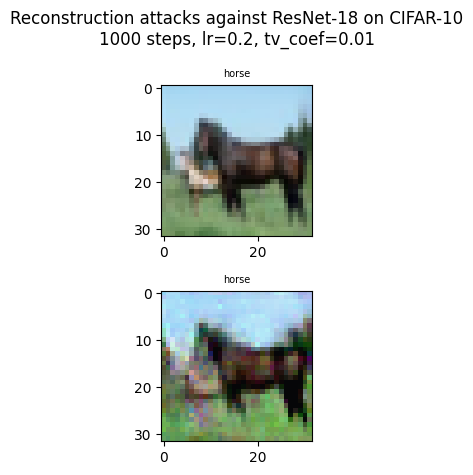

In [36]:
test_reconstruction(net, Subset(mini_train_set, [12]), n=1, steps=1000, lr=0.2, tv_coef=0.01)

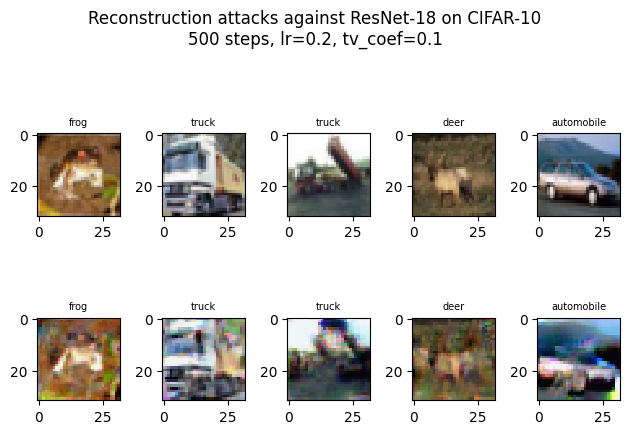

In [37]:
test_reconstruction(net, mini_train_set, steps=500, lr=0.2)

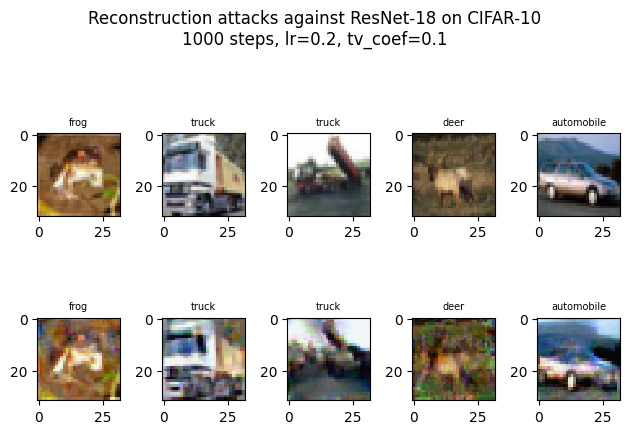

In [38]:
test_reconstruction(net, mini_train_set)

With enough reconstruction steps, many of the images can be leaked from the gradients with relatively high fidelity.

### Poisoning

In [39]:
from image_classification.datasets import UpdatableDataset
from image_classification.nn import MetricLogger

def train_epoch_with_poisons(
        model: nn.Module,
        dataloader: DataLoader,
        criterion: _Loss,
        optimizer: Optimizer,
        inverter: GradientInverter,
        alpha_poison=0.2,
        keep_pbars=True,
    ) -> tuple[UpdatableDataset, MetricLogger]:
    model.train()
    logger = MetricLogger(
        metric,
        device=device,
        desc='Train loop', total=len(dataloader.dataset), keep_pbars=keep_pbars,
    )
    poison_set = UpdatableDataset()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        # TODO: handle losses that don't reduce
        loss = criterion(logits, y)
        # TODO: backpropagate on each loss element (and model.zero_grad() every time)
        loss.backward()

        # --- poisoning attack
        X_p, y_p = inverter.attack(model, criterion)
        poison_set.append(X_p, y_p)

        logits_p = model(X_p.unsqueeze(0))
        loss_p = alpha_poison * criterion(logits_p, y_p.unsqueeze(0))
        # This adds to `loss` model gradients due to gradient accumulation
        loss_p.backward()
        # ---

        optimizer.step()
        optimizer.zero_grad()

        # FIXME: does not include X_p, y_p, logits_p, loss_p
        # TODO: log loss on poisons
        # TODO: display some poisons
        logger.compute_metrics(X, y, logits, loss.item())
    
    logger.finish()
    return poison_set, logger

In [40]:
def train_loop_with_poisons(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: _Loss,
        optimizer: Optimizer,
        epochs: int,
        inverter: GradientInverter,
        alpha_poison=0.05,
        metric=metric,
    ) -> TensorDataset:
    poison_set = UpdatableDataset()
    for epoch in trange(epochs, desc='Train epochs', unit='epoch', leave=True):
        poison_set_epoch, _ = train_epoch_with_poisons(
            model, train_loader,
            criterion, optimizer,
            inverter, alpha_poison=alpha_poison
        )
        poison_set.extend(poison_set_epoch)
        test_epoch(model, val_loader, criterion, keep_pbars=True, metric=metric)
    return poison_set.to_tensor_dataset()

### Orthogonal Gradient inverting attack

In [ ]:
estimator = OmniscientGradientEstimator(train_loader.batch_size)
sample_init = SampleInitRandomNoise(aux_data)
inverter = GradientInverter(
    GradientAttack.ORTHOGONAL,
    estimator,
    steps=5,
    sample_init=sample_init,
    tv_coef=0.0,
    lr=0.3,
)

In [42]:
# SGD is more vulnerable to gradient attacks
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs,
    inverter, alpha_poison=0.2,
)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:13<00:00, 546.05it/s, MulticlassAccuracy=0.416, avg_loss=1.98]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5296.55it/s, MulticlassAccuracy=0.297, avg_loss=1.87]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:14<00:00, 536.11it/s, MulticlassAccuracy=0.479, avg_loss=1.66]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5073.06it/s, MulticlassAccuracy=0.361, avg_loss=1.79]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 525.63it/s, MulticlassAccuracy=0.52, avg_loss=1.5]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5292.36it/s, MulticlassAccuracy=0.423, avg_loss=1.65]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 527.80it/s, MulticlassAccuracy=0.579, avg_loss=1.39]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5215.75it/s, MulticlassAccuracy=0.447, avg_loss=1.57]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 525.76it/s, MulticlassAccuracy=0.604, avg_loss=1.29]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5095.20it/s, MulticlassAccuracy=0.427, avg_loss=1.53]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 525.24it/s, MulticlassAccuracy=0.656, avg_loss=1.2]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5187.36it/s, MulticlassAccuracy=0.461, avg_loss=1.53]


Training progress is slowed down by a lot, however accuracy does not drop as much as with Gradient Ascent.

### Gradient Ascent inverting attack

In [ ]:
estimator = OmniscientGradientEstimator(train_loader.batch_size)
sample_init = SampleInitRandomNoise(aux_data)
inverter = GradientInverter(
    GradientAttack.ASCENT,
    estimator,
    steps=5,
    sample_init=sample_init,
    tv_coef=0.0,
    lr=0.3,
)

In [44]:
# SGD is more vulnerable to gradient attacks
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs,
    inverter, alpha_poison=0.2,
)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 518.60it/s, MulticlassAccuracy=0.35, avg_loss=2.04]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5039.24it/s, MulticlassAccuracy=0.277, avg_loss=1.94]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 521.01it/s, MulticlassAccuracy=0.498, avg_loss=1.69]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5094.13it/s, MulticlassAccuracy=0.332, avg_loss=1.84]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 518.46it/s, MulticlassAccuracy=0.533, avg_loss=1.53]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5045.57it/s, MulticlassAccuracy=0.383, avg_loss=1.75]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 522.04it/s, MulticlassAccuracy=0.551, avg_loss=1.41]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5182.95it/s, MulticlassAccuracy=0.354, avg_loss=1.87]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 525.78it/s, MulticlassAccuracy=0.623, avg_loss=1.32]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5093.71it/s, MulticlassAccuracy=0.421, avg_loss=1.6]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 515.78it/s, MulticlassAccuracy=0.615, avg_loss=1.24]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5041.85it/s, MulticlassAccuracy=0.457, avg_loss=1.62]


TODO: test with more poison steps or different lr for poison optimizer

#### Lower poisoning rate

In [45]:
net = ResNet18(num_classes=num_classes).to(device)

In [46]:
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs,
    inverter, alpha_poison=0.05,
)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 512.18it/s, MulticlassAccuracy=0.399, avg_loss=2]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5014.38it/s, MulticlassAccuracy=0.201, avg_loss=1.92]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 509.41it/s, MulticlassAccuracy=0.552, avg_loss=1.68]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4991.76it/s, MulticlassAccuracy=0.368, avg_loss=1.68]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 510.21it/s, MulticlassAccuracy=0.544, avg_loss=1.52]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4975.55it/s, MulticlassAccuracy=0.444, avg_loss=1.6]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 520.12it/s, MulticlassAccuracy=0.568, avg_loss=1.4]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5172.86it/s, MulticlassAccuracy=0.42, avg_loss=1.59]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 532.66it/s, MulticlassAccuracy=0.59, avg_loss=1.29]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5336.20it/s, MulticlassAccuracy=0.412, avg_loss=1.69]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:13<00:00, 547.21it/s, MulticlassAccuracy=0.614, avg_loss=1.21]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5325.34it/s, MulticlassAccuracy=0.416, avg_loss=1.82]


#### Using Adam optimizer for training

In [47]:
net = ResNet18(num_classes=num_classes).to(device)

In [48]:
# Adam regularizes the parameters so it is more robust to gradient attacks
opt = make_optimizer(net, opt_name='adam', lr=lr)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs,
    inverter, alpha_poison=0.2,
);

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 532.19it/s, MulticlassAccuracy=0.607, avg_loss=1.46]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5310.95it/s, MulticlassAccuracy=0.421, avg_loss=1.75]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:14<00:00, 535.70it/s, MulticlassAccuracy=0.701, avg_loss=1.05]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5282.01it/s, MulticlassAccuracy=0.394, avg_loss=2.04]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:14<00:00, 534.71it/s, MulticlassAccuracy=0.765, avg_loss=0.867]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5339.89it/s, MulticlassAccuracy=0.618, avg_loss=1.22]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 531.76it/s, MulticlassAccuracy=0.785, avg_loss=0.735]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5106.01it/s, MulticlassAccuracy=0.575, avg_loss=1.8]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 508.98it/s, MulticlassAccuracy=0.829, avg_loss=0.643]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4952.21it/s, MulticlassAccuracy=0.634, avg_loss=1.31]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 513.34it/s, MulticlassAccuracy=0.817, avg_loss=0.563]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5320.90it/s, MulticlassAccuracy=0.596, avg_loss=1.46]


Interestingly, test accuracy jumps from 40 % to 60 % in one epoch. Explanation?

## Machine unlearning

In [49]:
from image_classification.unlearning import gradient_descent, neg_grad_plus, unlearning_last_layers

In [50]:
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='sgd', lr=lr)
forget_set = train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs,
    inverter, alpha_poison=0.2,
)
forget_loader = DataLoader(forget_set, batch_size)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 529.90it/s, MulticlassAccuracy=0.377, avg_loss=2.06]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4771.40it/s, MulticlassAccuracy=0.254, avg_loss=1.85]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 507.32it/s, MulticlassAccuracy=0.499, avg_loss=1.67]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5069.43it/s, MulticlassAccuracy=0.382, avg_loss=1.89]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 531.48it/s, MulticlassAccuracy=0.506, avg_loss=1.52]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5252.39it/s, MulticlassAccuracy=0.373, avg_loss=1.91]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 520.72it/s, MulticlassAccuracy=0.486, avg_loss=1.41]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5273.19it/s, MulticlassAccuracy=0.416, avg_loss=1.69]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 530.96it/s, MulticlassAccuracy=0.548, avg_loss=1.31]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5089.66it/s, MulticlassAccuracy=0.437, avg_loss=1.65]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 526.14it/s, MulticlassAccuracy=0.585, avg_loss=1.23]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5197.57it/s, MulticlassAccuracy=0.388, avg_loss=1.73]


In [51]:
class Unlearning(Enum):
    GRADIENT_DESCENT = 0
    GRADIENT_ASCENT = 1
    NOISY_GRADIENT_DESCENT = 2
    NEG_GRAD_PLUS = 3
    CFK = 4
    EUK = 5
    SCRUB = 6

In [52]:
def unlearn(
        net: nn.Module,
        train_loader: DataLoader,
        forget_loader: DataLoader,
        criterion: _Loss,
        method: Unlearning,
    ):
    unlearner = deepcopy(net)
    
    match method:
        case Unlearning.GRADIENT_DESCENT:
            opt = make_optimizer(unlearner, opt_name='sgd', lr=lr)
            gradient_descent(
                unlearner, train_loader, val_loader,
                criterion, opt, epochs=1, keep_pbars=False
            )
        
        case Unlearning.NEG_GRAD_PLUS:
            opt = make_optimizer(unlearner, opt_name='sgd', lr=lr)
            for epoch in trange(10, desc='NegGrad+ epochs', unit='epoch', leave=True):
                neg_grad_plus(
                    unlearner, train_loader, forget_loader,
                    criterion, opt, keep_pbars=False
                )
    
        case Unlearning.EUK:
            opt = make_optimizer(unlearner, opt_name='adam', lr=lr)
            with unlearning_last_layers(unlearner, 6, 'euk'):
                train_loop(unlearner, train_loader, criterion, opt, epochs=1)
    
    return unlearner

#### No poisoning

TODO: quantify effect of poisoning in terms of loss recovery effort (epochs). Can the model ever recover from poisoning with enough steps?

In [53]:
clean_net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(clean_net, opt_name='sgd', lr=lr)
train_val_loop(
    clean_net, train_loader, val_loader,
    criterion, opt,
    epochs=epochs,
    metric=metric,
);
test_epoch(clean_net, val_loader, criterion, keep_pbars=True, metric=metric);

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1712.54it/s, MulticlassAccuracy=0.434, avg_loss=1.99]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5091.09it/s, MulticlassAccuracy=0.253, avg_loss=1.76]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1715.46it/s, MulticlassAccuracy=0.453, avg_loss=1.65]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1716.33it/s, MulticlassAccuracy=0.507, avg_loss=1.48]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5104.54it/s, MulticlassAccuracy=0.411, avg_loss=1.46]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1711.54it/s, MulticlassAccuracy=0.543, avg_loss=1.36]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1714.42it/s, MulticlassAccuracy=0.591, avg_loss=1.27]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5159.33it/s, MulticlassAccuracy=0.47, avg_loss=1.31]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1710.72it/s, MulticlassAccuracy=0.603, avg_loss=1.19]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5092.82it/s, MulticlassAccuracy=0.505, avg_loss=1.27]


#### No unlearning

In [54]:
test_epoch(net, val_loader, criterion, keep_pbars=True, metric=metric);

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5070.77it/s, MulticlassAccuracy=0.388, avg_loss=1.73]


#### Gradient descent

In [55]:
unlearner = unlearn(net, train_loader, forget_loader, criterion, Unlearning.GRADIENT_DESCENT)
test_epoch(unlearner, val_loader, criterion, keep_pbars=True, metric=metric);

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4798.71it/s, MulticlassAccuracy=0.474, avg_loss=1.25]


#### NegGrad+

In [56]:
unlearner = unlearn(net, train_loader, forget_loader, criterion, Unlearning.NEG_GRAD_PLUS)
test_epoch(unlearner, val_loader, criterion, keep_pbars=True, metric=metric);

NegGrad+ epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4943.03it/s, MulticlassAccuracy=0.442, avg_loss=1.44]


#### EUk ($k = 6$)

In [57]:
unlearner = unlearn(net, train_loader, forget_loader, criterion, Unlearning.EUK)
test_epoch(unlearner, val_loader, criterion, keep_pbars=True, metric=metric);

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:09<00:00, 4174.69it/s, avg_loss=1.21]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4864.93it/s, MulticlassAccuracy=0.453, avg_loss=1.3]


Although more extensive testing is required, unlearning methods do not fully restore accuracy, at least not with only one epoch. Why is gradient descent enough?

### Remaining tasks

- Refactoring
- Modify label optimization to force sparse logits (close to one-hot)
- Compare with results from article
- Use `Conv16` model for prototyping
- _Little is Enough_ attack (requires efficient gradient stddev estimation)
- Mean gradient estimation with auxiliary dataset
- Testing against unlearning
- Testing with different configs (optimizer, number of epochs, batch size, models)
- Quantify results of data poisoning in terms of slowdown (x% -> y% accuracy = z training epochs)
- Suggest other Hessian-based attacks